# Autism Diagnosis:

Here we are going to improve Autism Screening by creating predicting the likelihood of having this condition.
We have 22 features (a mix of a questionnaire and personal info) The training set is heavily imbalanced and it has only 800 entries. The evaluation method is roc_auc.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from pandas.api.types import CategoricalDtype
import os
import warnings
warnings.filterwarnings("ignore")

# Libraries:

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier 
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,RobustScaler
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier,VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [3]:
train_csv_path = "C:/Users/rohan/OneDrive/Desktop/rohan certificates/major/asd-predection/train.csv"
train = pd.read_csv(train_csv_path)
test_csv_path = "C:/Users/rohan/OneDrive/Desktop/rohan certificates/major/asd-predection/test.csv"
test = pd.read_csv(test_csv_path)


# EDA:

In [4]:
train.shape

(800, 22)

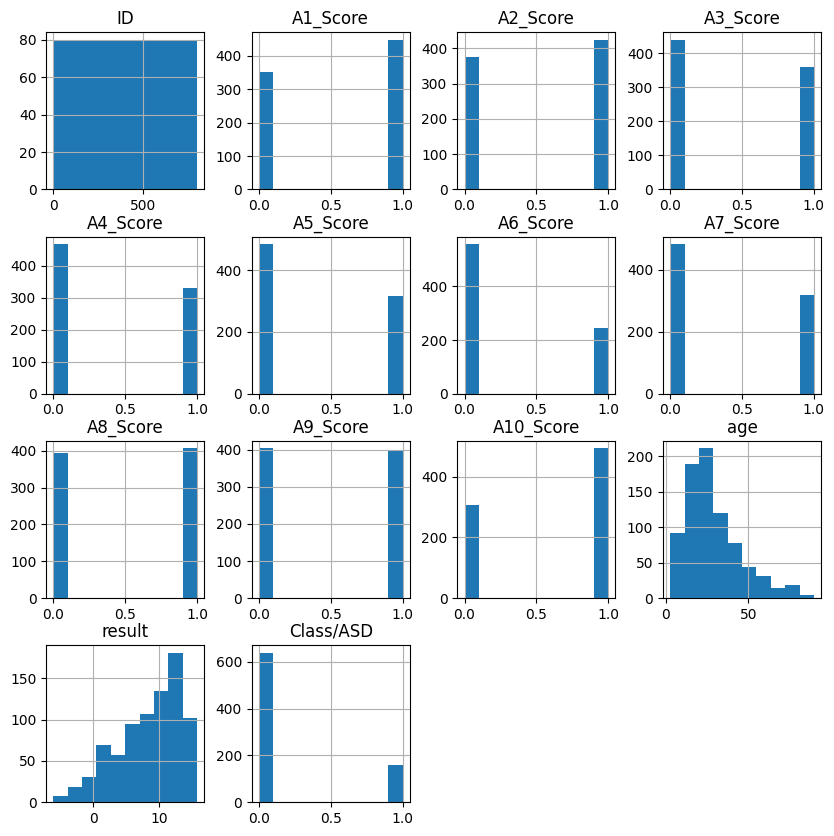

In [5]:
train.hist(figsize=(10,10))
plt.show()

In [6]:
test.shape

(200, 21)

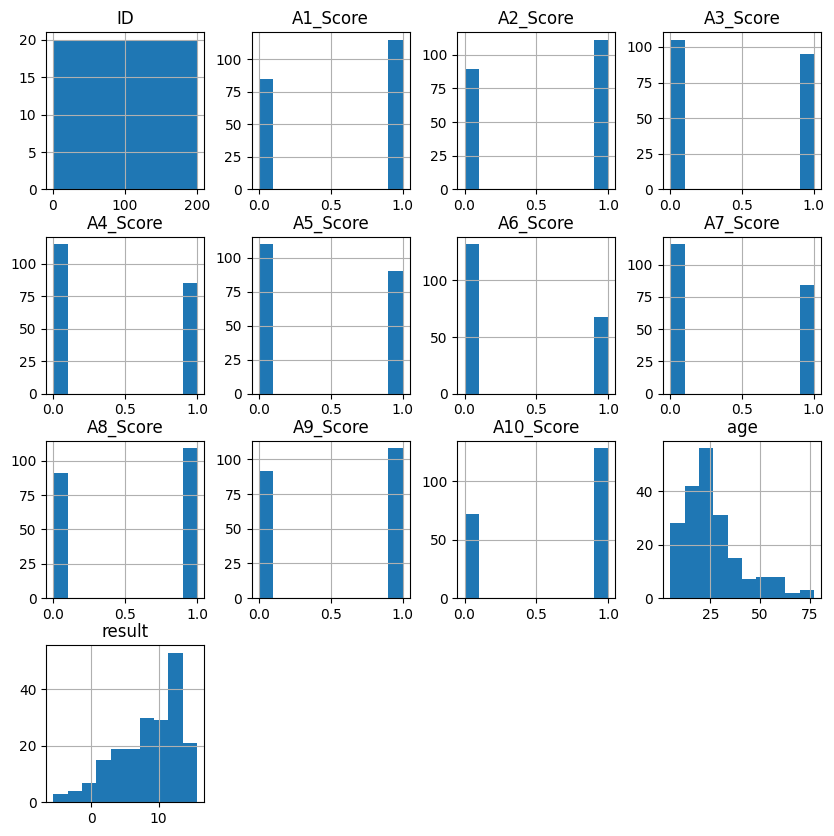

In [7]:
test.hist(figsize=(10,10))
plt.show()

<Axes: >

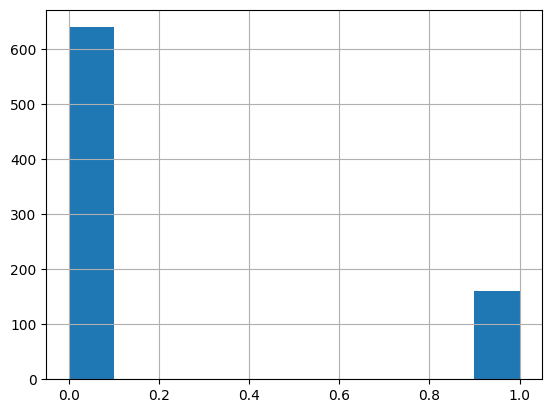

In [8]:
#Data is heavily imbalanced, so we'll need oversampling
train['Class/ASD'].hist()

In [9]:
#no nulls in the training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [10]:
#no nulls in the test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               200 non-null    int64  
 1   A1_Score         200 non-null    int64  
 2   A2_Score         200 non-null    int64  
 3   A3_Score         200 non-null    int64  
 4   A4_Score         200 non-null    int64  
 5   A5_Score         200 non-null    int64  
 6   A6_Score         200 non-null    int64  
 7   A7_Score         200 non-null    int64  
 8   A8_Score         200 non-null    int64  
 9   A9_Score         200 non-null    int64  
 10  A10_Score        200 non-null    int64  
 11  age              200 non-null    float64
 12  gender           200 non-null    object 
 13  ethnicity        200 non-null    object 
 14  jaundice         200 non-null    object 
 15  austim           200 non-null    object 
 16  contry_of_res    200 non-null    object 
 17  used_app_before 

In [11]:
train.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [12]:
test.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self


Based on the first few columns:

* we can see that ID is not relevant.

* seems like "age_desc" columns has just one value, I'm going to investigate to see if this is the case.

In [13]:
train.age_desc.value_counts()

age_desc
18 and more    800
Name: count, dtype: int64

In [14]:
test.age_desc.value_counts()

age_desc
18 and more    200
Name: count, dtype: int64

So the "age_desc" columns just has one value, it makes sense to drop it!

# Chi 2

I'll calculate the chi 2 score for categorical columns (the ones with discrete values) and the target.

In [15]:
def chi2_calc(df,target):
    scores=[]
    for col in df.columns:
        ct=pd.crosstab(df[col],target)
        stat,p,dof,expected=chi2_contingency(ct)
        scores.append(p)
    return pd.DataFrame(scores, index=df.columns, columns=['P value']).sort_values(by='P value')

In [16]:
chi2_calc(train[train.columns.difference(['age', 'result'])],train['Class/ASD'])

,P value
Class/ASD,1.207742e-174
A6_Score,1.353680e-52
A4_Score,4.884021e-45
A9_Score,9.762852e-39
A5_Score,1.793100e-38
A3_Score,2.400756e-38
A7_Score,5.621313e-37
ethnicity,6.321928e-33
A2_Score,1.399801e-25
austim,1.006056e-23


The chi2 score list shows that the last four features have a p-value over 0.05, so the relation between these features and the target is not significant. therefore, it's better if we drop these four.

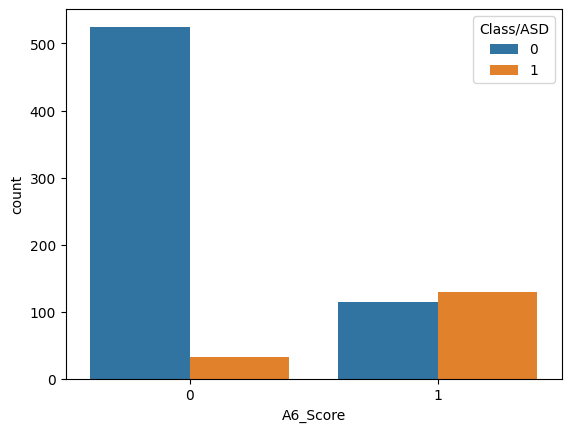

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# just for demonstration, in the plot there is a significant difference between the ratio of the classes
# when we change the A6-score, which suggests a strong relation between this feature and the target
sns.countplot(x='A6_Score', data=train, hue='Class/ASD')
plt.show()


# Dropping the irrelevant features:

In [18]:
train_set=train.copy()
test_set=test.copy()

#age_desc doesn't change and ID is irrelevant
train_set.drop(['age_desc','ID'],axis=1,inplace=True)

test_set.drop(['age_desc','ID'],axis=1,inplace=True)

In [19]:
#Dropping useless features using chi 2

train_set.drop(['gender','used_app_before'],axis=1,inplace=True)
test_set.drop(['gender','used_app_before'],axis=1,inplace=True)

In [20]:
#separating the target column from the rest of the data
y=train_set.pop('Class/ASD')

# Using K-fold to separate train/validation:

In [21]:
#to group ages in 4, as a part of encoding
def age_grouper(df):
    for row in range(df.shape[0]):
        if df.age.iloc[row]<=14: df.age.iloc[row]=1
        if 14<df.age.iloc[row]<=24: df.age.iloc[row]=2
        if 24<df.age.iloc[row]<=64: df.age.iloc[row]=3
        if 64<df.age.iloc[row]: df.age.iloc[row]=4

In [22]:
np.random.seed(1) #I'm using this because there's some
#randomness in how the selectors work, without this, in each run we get different results
kf = StratifiedKFold(n_splits=2, random_state=None,shuffle=False) #for cross validation/ random_state
# is None because shuffle is False
score=[]

for train_index, val_index in kf.split(train_set,y):
    
    #indices for train and validation sets
    X_train, X_val =train_set.iloc[train_index,:], train_set.iloc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]
    
    #******************************* CLEANING ***********************************

    #for train set
    X_train.ethnicity=X_train.ethnicity.str.replace('others','Others',regex=False)
    X_train.ethnicity=X_train.ethnicity.str.replace('?','Others',regex=False)
    X_train.relation=X_train.relation.str.replace('?','Others',regex=False)
    X_train.relation=X_train.relation.str.replace('Health care professional','Others',regex=False)
    
    
    #for validation set:
    X_val.ethnicity=X_val.ethnicity.str.replace('others','Others',regex=False)
    X_val.ethnicity=X_val.ethnicity.str.replace('?','Others',regex=False)
    X_val.relation=X_val.relation.str.replace('?','Others',regex=False)
    X_val.relation=X_val.relation.str.replace('Health care professional','Others',regex=False)

  
    #***************************************ENCODING****************************************** 
    
    #FOR ENCODING USE THE TRAINING VALUES, DO NOT CALCULATE THEM AGAIN FOR THE TEST SET!
    
    le=LabelEncoder()
    for col in ['jaundice','austim']:
        
        #for the training set:
        X_train[col]=le.fit_transform(X_train[col])
        
        #for the validation set:
        X_val[col]=le.transform(X_val[col])
         

    #*********************Encoding Relation Column***************************
    
    #create an encoding map, using the training set, then implementing it on val and test sets
    rel=X_train.relation.value_counts()
    rel=dict(zip(rel.index,range(len(rel))))
    
    #for the training set:
    X_train.relation=X_train.relation.map(rel)
    
    #for the validation set: if there's a category not present in the map, we'll assign sth. to it
    X_val.relation=X_val.relation.map(rel)
    X_val.relation[X_val.relation.isna()]=len(rel)
    
    
    
    #*********************Encoding Ethnicity Column***************************
    
    #create an encoding map, using the training set, then implementing it on val and test sets
    eth=X_train.ethnicity.value_counts()
    eth=dict(zip(eth.index,range(len(eth))))
    
    #for the training set:
    X_train.ethnicity=X_train.ethnicity.map(eth)
    
    #for the validation set: if there's a category not present in the map, we'll assign sth. to it
    X_val.ethnicity=X_val.ethnicity.map(eth)
    X_val.ethnicity[X_val.ethnicity.isna()]=len(eth)
    
    
    #*****************************Encoding Country Of Res******************************
    
    #create an encoding map, using the training set, then implementing it on val and test sets
    cont=X_train.contry_of_res.value_counts()
    cont=dict(zip(cont.index,range(len(cont))))
    
    #for the training set:
    X_train.contry_of_res=X_train.contry_of_res.map(cont)
    
    #for the validation set: if there's a category not present in the map, we'll assign sth. to it
    X_val.contry_of_res=X_val.contry_of_res.map(cont)
    X_val.contry_of_res[X_val.contry_of_res.isna()]=len(cont)

    #***************************Age Grouping***********************************
    
#     age_grouper(X_train)
#     age_grouper(X_val)
            
    #*******************************Standardization*************************
    ss=StandardScaler()
    rs=RobustScaler()
    X_train[['result','age']]=rs.fit_transform(X_train[['result','age']])
    X_val[['result','age']]=rs.transform(X_val[['result','age']])



In [23]:
# Model Selection Now, checking various type of model and select the best model all of them

In [24]:
model_list = ['KNearestNeighbours', 'DecisionTree', 'LGBM','XGBRF','CatBoostClassifier','RandomForest','Logistic Regression', 'SVC' ]

In [25]:
# K Neighbors Classifier

kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(X_train,y_train)
y_pred=pd.DataFrame(kn_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644])

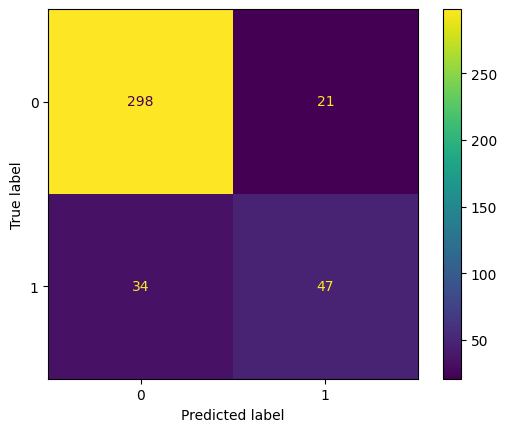

In [26]:
cm = confusion_matrix(y_val, kn_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [27]:
#DecissionTree
dt_clf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0, criterion='entropy')
dt_clf.fit(X_train, y_train)
y_pred=pd.DataFrame(dt_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541])

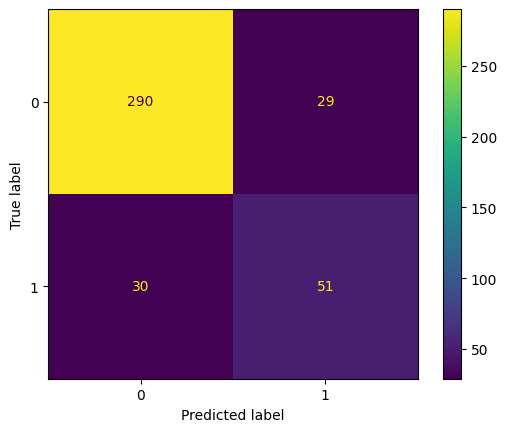

In [28]:
cm = confusion_matrix(y_val, dt_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [29]:
#  lightgbm 
import lightgbm
lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
lgb_clf.fit(X_train, y_train)
y_pred=pd.DataFrame(lgb_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

[LightGBM] [Info] Number of positive: 80, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


array([0.88091644, 0.78857541, 0.923391  ])

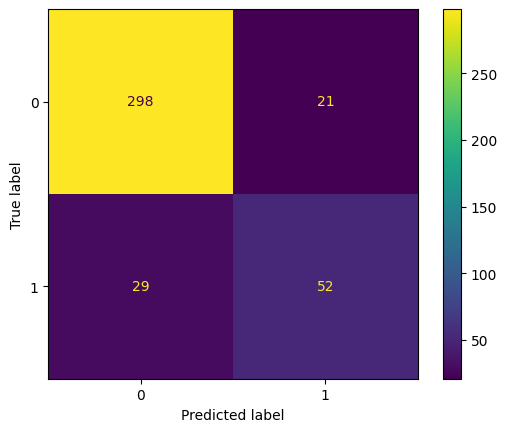

In [30]:
cm = confusion_matrix(y_val, lgb_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [31]:
# xgbrf classifier
import xgboost
xgb_clf = xgboost.XGBRFClassifier(max_depth=4, random_state=1)
xgb_clf.fit(X_train, y_train)
y_pred=pd.DataFrame(xgb_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  , 0.92329425])

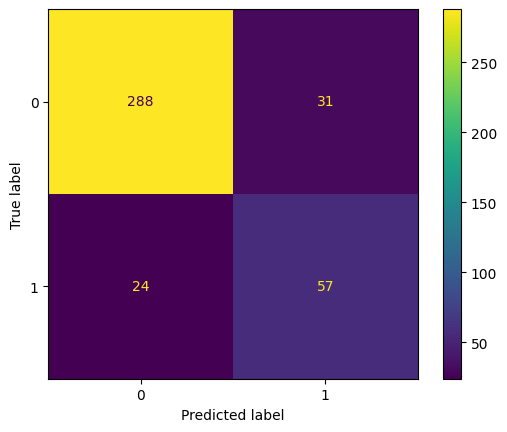

In [32]:

cm = confusion_matrix(y_val, xgb_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [33]:
#cathboost
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(iterations=100,depth=10,random_state=42,auto_class_weights='Balanced')
cat_model.fit(X_train,y_train,plot=False,verbose=0)
y_pred=pd.DataFrame(cat_model.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  , 0.92329425, 0.92542281])

In [34]:
# RF
clf_rf = RandomForestClassifier()      
clf_rf.fit(X_train,y_train)
y_pred=pd.DataFrame(clf_rf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  , 0.92329425, 0.92542281,
       0.92325554])

In [35]:
# logistic regression

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred=pd.DataFrame(log_reg.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  , 0.92329425, 0.92542281,
       0.92325554, 0.93060877])

In [36]:
# svc

clf = SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  , 0.92329425, 0.92542281,
       0.92325554, 0.93060877, 0.51234568])

In [37]:
len(score)
len(model_list)

8

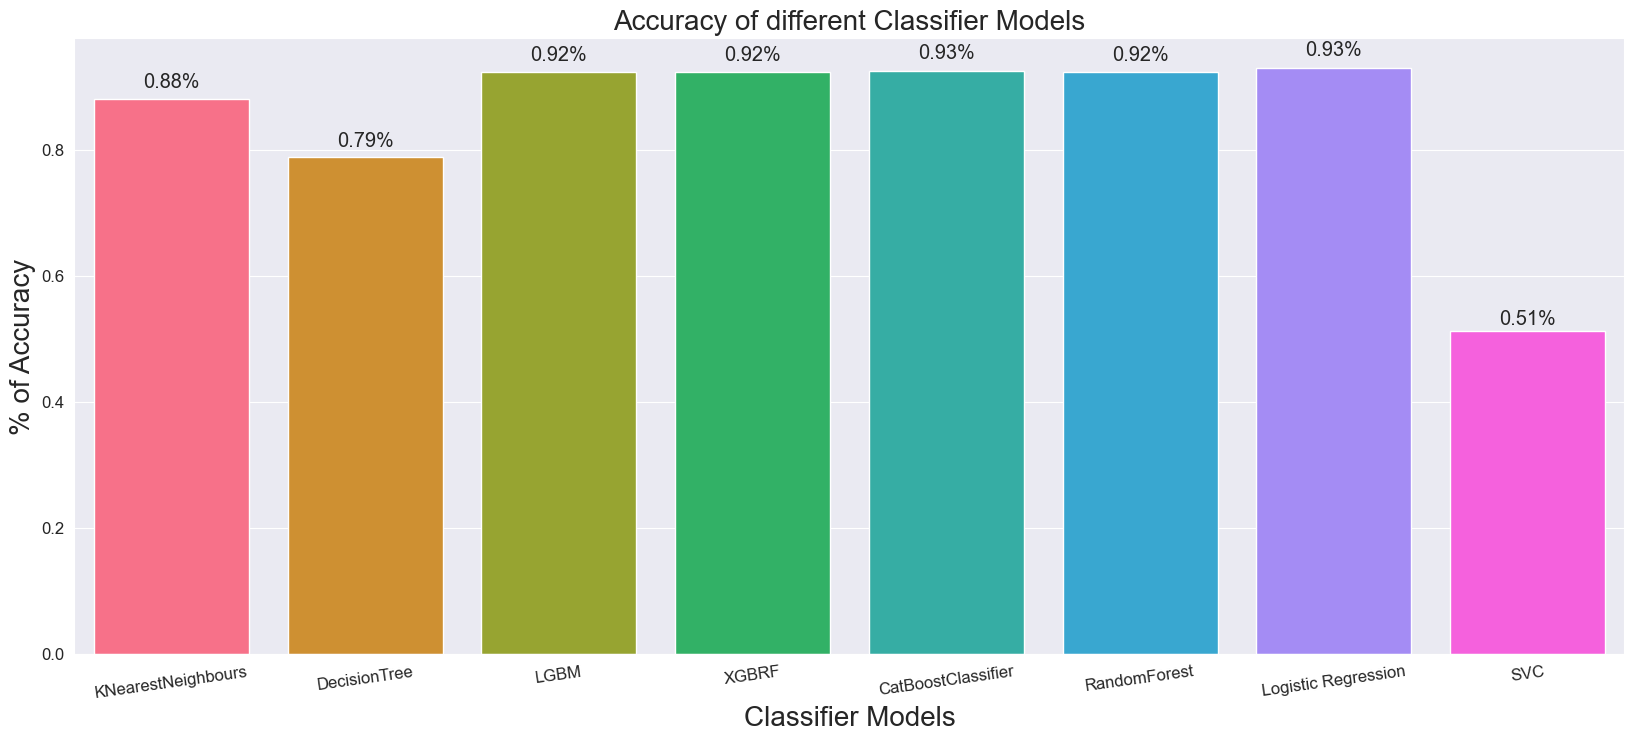

In [38]:
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=score, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

# Transforming Test Set

In [39]:
#Cleaning:
test_set.ethnicity=test_set.ethnicity.str.replace('?','Others',regex=False)
test_set.relation=test_set.relation.str.replace('?','Others',regex=False)
test_set.relation=test_set.relation.str.replace('?','Others',regex=False)
test_set.relation=test_set.relation.str.replace('Health care professional','Others',regex=False)

#Encoding:

test_set['jaundice']=le.transform(test_set['jaundice'])
test_set['austim']=le.transform(test_set['austim'])


test_set.relation=test_set.relation.map(rel)
test_set.relation[test_set.relation.isna()]=len(rel)

test_set.ethnicity=test_set.ethnicity.map(eth)
test_set.ethnicity[test_set.ethnicity.isna()]=len(eth)

test_set.contry_of_res=test_set.contry_of_res.map(cont)
test_set.contry_of_res[test_set.contry_of_res.isna()]=len(cont)

# age_grouper(test_set)

#result of Scaling:
# test_set[['result','age']]=ss.transform(test_set[['result','age']])
# test_set[['result','age']]=rs.transform(test_set[['result','age']])

#result of feature engineering:

# test_set=test_set[cols]

In [40]:
pd.DataFrame(test_set).head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,ethnicity,jaundice,austim,contry_of_res,result,relation
0,1,1,0,0,1,1,0,0,1,1,15.599481,0,1,0,1.0,12.399055,0
1,1,0,0,0,0,0,0,1,0,0,27.181099,3,0,0,34.0,6.551598,0
2,1,1,1,0,1,1,0,1,1,1,31.643906,0,1,0,33.0,3.180663,0
3,0,0,0,0,0,0,0,0,0,0,25.369210,1,0,0,1.0,2.220766,0
4,0,0,0,1,0,0,0,0,0,0,9.078580,1,0,0,16.0,7.252028,0


# Create Submission:

In [41]:
predictions = pd.DataFrame(cat_model.predict_proba(test_set))[1].values

output = pd.DataFrame({'ID': test['ID'], 'Class/ASD': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [42]:
#output.head(20)

FOR WEB Reguirement  

In [43]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Initialize and train the K Neighbors Classifier
kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = kn_clf.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)

# Print the ROC AUC score
print(f"ROC AUC score for K Neighbors Classifier: {roc_auc}")

# Save the trained model to a file
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(kn_clf, f)


ROC AUC score for K Neighbors Classifier: 0.8809164441348349


In [44]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0, criterion='entropy')
dt_clf.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = dt_clf.predict_proba(X_val)[:, 1]
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_clf, f)


In [45]:
import lightgbm

lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
lgb_clf.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = lgb_clf.predict_proba(X_val)[:, 1]
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_clf, f)


[LightGBM] [Info] Number of positive: 80, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [46]:
import xgboost

xgb_clf = xgboost.XGBRFClassifier(max_depth=4, random_state=1)
xgb_clf.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = xgb_clf.predict_proba(X_val)[:, 1]
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_clf, f)


In [47]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=100, depth=10, random_state=42, auto_class_weights='Balanced')
cat_model.fit(X_train, y_train, plot=False, verbose=0)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = cat_model.predict_proba(X_val)[:, 1]
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('cat_model.pkl', 'wb') as f:
    pickle.dump(cat_model, f)


In [48]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()      
clf_rf.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = clf_rf.predict_proba(X_val)[:, 1]
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(clf_rf, f)


In [49]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = log_reg.predict_proba(X_val)[:, 1]
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(log_reg, f)


In [50]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the validation set and calculate ROC AUC score
y_pred = clf.predict(X_val)
score.append(roc_auc_score(y_val, y_pred))

# Save the trained model to a file
with open('svc_model.pkl', 'wb') as f:
    pickle.dump(clf, f)


In [51]:
from sklearn.preprocessing import StandardScaler

#result of Scaling:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

# Save the scaler object to a file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(ss, file)
